# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

DATA Task

The objective of this task to conduct a multivariate analysis to identiy and quantify the impact of various features on the price of used cars. This requires a dataset containing variables such as manufacturer, model, age, odometer reading, condition, price, geograhical location, and other relavant features. After cleaning-up / pre-processing the data to handle missing values, duplicate values and outliers, feature selection techniques will be applied to identify key features that impact the price of the car. Multiple regression models will be developed and validated to estimate the price of the car based on the key features. The best regression model will be chosen based on the lowest error. The final model will be used to provide insights to used car dealers to understand what drives the price of a used car with the ultimate objective to flip used cars for profit.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression, RidgeCV
from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

In [22]:
vehicles = pd.read_csv("data/vehicles.csv")
vehicles.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [23]:
print("Rows Size, Columns Size:", vehicles.shape)
print(vehicles.info())

Rows Size, Columns Size: (426880, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state     

In [24]:
print("Empty fields for each column:")
print(vehicles.isnull().sum())

# Calculate the percentage of  rows with any missing values
percentage_rows_missing_values = vehicles.isnull().any(axis=1).mean() * 100

print(f"Mean Percentage of rows with missing values: {percentage_rows_missing_values:.2f}%")

Empty fields for each column:
id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64
Mean Percentage of rows with missing values: 91.83%


In [25]:
print("Duplicate entries:", vehicles.duplicated().sum())
print("No duplicate entries found in the dataset.")

Duplicate entries: 0
No duplicate entries found in the dataset.


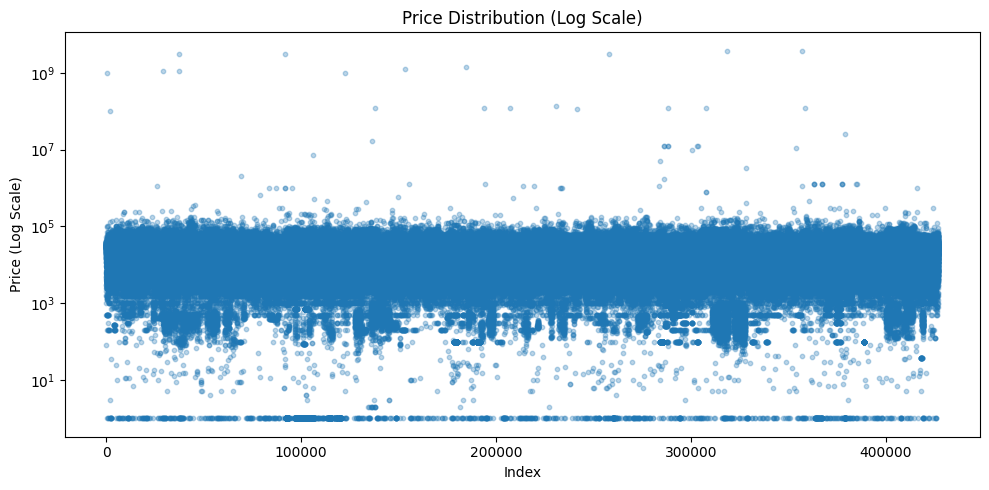

In [26]:
# Scatter Plot of Price vs Index
plt.figure(figsize=(10, 5))
plt.scatter(vehicles.index, vehicles["price"], alpha=0.3, s=10)
plt.yscale("log")
plt.title("Price Distribution (Log Scale)")
plt.xlabel("Index")
plt.ylabel("Price (Log Scale)")
plt.tight_layout()
plt.savefig("images/scatter-plot-price.png")
plt.show()

#
Based on the above scatter plot, we can tell there are plenty of outliers. We can restrict the price range for e.g from 1000 to 10000 to keep the computation meaningful.

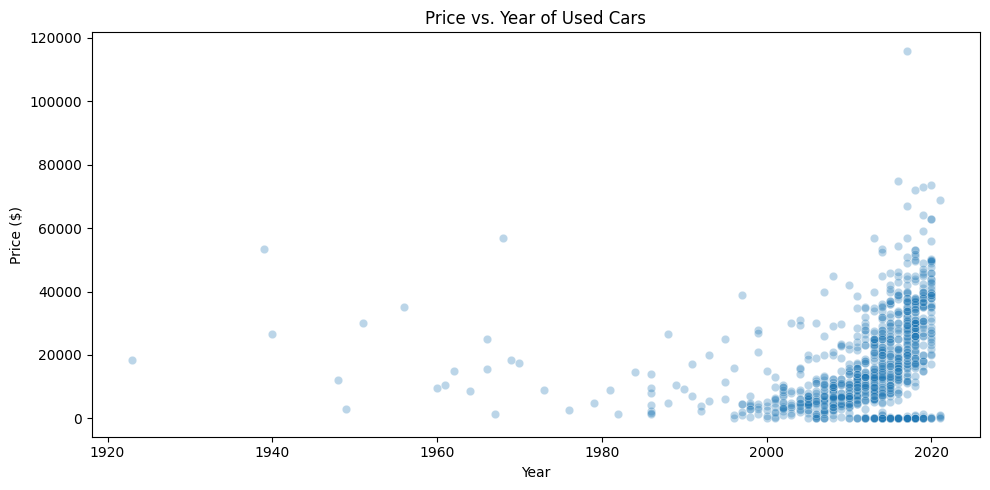

In [27]:
# Price vs Year Scatter Plot
plt.figure(figsize=(10, 5))
sns.scatterplot(data=vehicles.sample(1000), x="year", y="price", alpha=0.3)
plt.title("Price vs. Year of Used Cars")
plt.xlabel("Year")
plt.ylabel("Price ($)")
plt.tight_layout()
plt.savefig("images/used-cars-plot.png")
plt.show()

In [28]:
print("This plot shows a clear trend that a car with less no of years i.e. newer cars are expensive whereas older cars are cheaper.")


This plot shows a clear trend that a car with less no of years i.e. newer cars are expensive whereas older cars are cheaper.


Observations

* Vehicles data is a combination of numeric and categorical features and each will require its own preprocessing method.
* Data contains fields that aren't of higher priority for e.g. id.
* Thre are plenty of empty fields. So data clean up will be required before building and validating a model.

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [29]:
# Dropping irrelevant columns that do not contribute to the price prediction
drop_columns = ["id", "VIN", "region", "state"]
df_clean = vehicles.drop(columns=drop_columns)

print(df_clean.info())

# Filling missing values for numeric columns with median
numeric_cols = ["year", "price", "odometer"]
for col in numeric_cols:
    median_value = df_clean[col].median()
    df_clean.fillna({col: median_value}, inplace=True)

# Filling missing values for categorical columns with 'Unknown'
categorical_cols = [
    "manufacturer",
    "model",
    "condition",
    "cylinders",
    "fuel",
    "title_status",
    "transmission",
    "drive",
    "type",
    "size"
]
for col in categorical_cols:
    df_clean.fillna({col: "Unknown"}, inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   year          425675 non-null  float64
 2   manufacturer  409234 non-null  object 
 3   model         421603 non-null  object 
 4   condition     252776 non-null  object 
 5   cylinders     249202 non-null  object 
 6   fuel          423867 non-null  object 
 7   odometer      422480 non-null  float64
 8   title_status  418638 non-null  object 
 9   transmission  424324 non-null  object 
 10  drive         296313 non-null  object 
 11  size          120519 non-null  object 
 12  type          334022 non-null  object 
 13  paint_color   296677 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 45.6+ MB
None


In [30]:
# Removing outliers using z score for price, odometer, and year
for col in numeric_cols:
    z_scores = stats.zscore(df_clean[col])
    abs_z_scores = np.abs(z_scores)
    filtered_entries = abs_z_scores < 3
    df_clean = df_clean[filtered_entries]

# Convert float columns to int
df_clean = df_clean.astype({"year": "int", "odometer": "int"})

print("DataFrame info after cleaning:")
print(df_clean.info())

DataFrame info after cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 416803 entries, 0 to 426879
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   price         416803 non-null  int64 
 1   year          416803 non-null  int64 
 2   manufacturer  416803 non-null  object
 3   model         416803 non-null  object
 4   condition     416803 non-null  object
 5   cylinders     416803 non-null  object
 6   fuel          416803 non-null  object
 7   odometer      416803 non-null  int64 
 8   title_status  416803 non-null  object
 9   transmission  416803 non-null  object
 10  drive         416803 non-null  object
 11  size          416803 non-null  object
 12  type          416803 non-null  object
 13  paint_color   290584 non-null  object
dtypes: int64(3), object(11)
memory usage: 47.7+ MB
None


In [31]:
# Check the shape of the DataFrame after removing outliers

print(df_clean.shape)
print(df_clean.describe())

(416803, 14)
              price           year       odometer
count  4.168030e+05  416803.000000  416803.000000
mean   1.783664e+04    2012.272484   92123.217580
std    7.147701e+04       6.160722   63911.048192
min    0.000000e+00    1983.000000       0.000000
25%    5.900000e+03    2009.000000   38681.500000
50%    1.398500e+04    2014.000000   85548.000000
75%    2.650000e+04    2017.000000  133412.500000
max    2.500300e+07    2022.000000  605000.000000


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [32]:
# Split the cleaned data set into training and test sets

X_train, X_test, y_train, y_test = train_test_split(
    df_clean.drop(columns=["price"]), df_clean["price"], test_size=0.2, random_state=42
)

In [33]:
# Define the categorical and numerical columns for preprocessing
categorical_col = X_train.select_dtypes(include=["object"]).columns
numerical_col = X_train.select_dtypes(include=["int64"]).columns

In [ ]:
# Preprocess the data using ColumnTransformer and Pipeline
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("pfeatures", PolynomialFeatures(degree=2, include_bias=False))
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numerical_col),
        ("categorical", categorical_transformer, categorical_col),
    ],
    remainder="drop",
)

In [35]:
# Create Linear Regression model pipeline

lr_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LinearRegression()),
    ]
)
lr_pipeline.fit(X_train, y_train)

lr_train_predictions = lr_pipeline.predict(X_train)
lr_test_predictions = lr_pipeline.predict(X_test)

lr_mse_train = mean_squared_error(y_train, lr_train_predictions)
lr_mse_test = mean_squared_error(y_test, lr_test_predictions)

lr_train_score = lr_pipeline.score(X_train, y_train)
lr_test_score = lr_pipeline.score(X_test, y_test)
print(f"Linear Regression Train Score: {lr_train_score:.2f}")
print(f"Linear Regression Test Score: {lr_test_score:.2f}")

print(f"Linear Regression Train MSE: {lr_mse_train:.2f}")
print(f"Linear Regression Test MSE: {lr_mse_test:.2f}")

print(f"Linear Regression Test RMSE: {np.sqrt(lr_mse_test):.2f}")

Linear Regression Train Score: 0.05
Linear Regression Test Score: 0.02
Linear Regression Train MSE: 4189045916.62
Linear Regression Test MSE: 7781520518.93
Linear Regression Test RMSE: 88212.93


In [36]:
# Create Ridge Regression model with GridSearchCV
ridge_params = {"ridge__alpha": [0.0001, 0.001, 0.01, 1.0, 10.0, 100.0, 1000.0]}

ridge_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("ridge", Ridge()),
    ]
)

ridge_grid_search = GridSearchCV(
    ridge_pipeline, ridge_params, cv=5, scoring="neg_mean_squared_error"
)

ridge_grid_search.fit(X_train, y_train)
print(f"Best Ridge Regression Alpha: {ridge_grid_search.best_params_['ridge__alpha']}")
best_estimator_ridge = ridge_grid_search.best_estimator_

# get MSE for Ridge Regression with best alpha
ridge_train_predictions = best_estimator_ridge.predict(X_train)
ridge_test_predictions = best_estimator_ridge.predict(X_test)
ridge_mse_train = mean_squared_error(y_train, ridge_train_predictions)
ridge_mse_test = mean_squared_error(y_test, ridge_test_predictions)

print(f"Ridge Regression Train MSE: {ridge_mse_train:.2f}")
print(f"Ridge Regression Test MSE: {ridge_mse_test:.2f}")
print(f"Ridge Regression Test RMSE: {np.sqrt(ridge_mse_test):.2f}")

Best Ridge Regression Alpha: 1.0
Ridge Regression Train MSE: 4199007252.29
Ridge Regression Test MSE: 7782448460.53
Ridge Regression Test RMSE: 88218.19


In [37]:
# Create Lasso Regression model pipeline
lasso_params = {"model__alpha": [0.1, 1.0, 10.0, 100.0]}

lasso_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", Lasso()),
    ]
)
lasso_pipeline.fit(X_train, y_train)
lasso_train_predictions = lasso_pipeline.predict(X_train)
lasso_test_predictions = lasso_pipeline.predict(X_test)
lasso_mse_train = mean_squared_error(y_train, lasso_train_predictions)
lasso_mse_test = mean_squared_error(y_test, lasso_test_predictions)
lasso_train_score = lasso_pipeline.score(X_train, y_train)
lasso_test_score = lasso_pipeline.score(X_test, y_test)
print(f"Lasso Regression Train MSE: {lasso_mse_train:.2f}")
print(f"Lasso Regression Test MSE: {lasso_mse_test:.2f}")
print(f"Lasso Regression Train Score: {lasso_train_score:.2f}")
print(f"Lasso Regression Test Score: {lasso_test_score:.2f}")
print(f"Lasso Regression Test RMSE: {np.sqrt(lasso_mse_test):.2f}")

Lasso Regression Train MSE: 4232880562.14
Lasso Regression Test MSE: 7808673388.57
Lasso Regression Train Score: 0.04
Lasso Regression Test Score: 0.02
Lasso Regression Test RMSE: 88366.70


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [38]:
#Extract the feature names and coefficients from the best Ridge Regression model
feature_names = best_estimator_ridge.named_steps["preprocessor"].get_feature_names_out()
coefficients = best_estimator_ridge.named_steps["ridge"].coef_

# Create a DataFrame to display feature names and their corresponding coefficients
feature_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
feature_df.sort_values(by="Coefficient", ascending=False, inplace=True)
feature_df.head(5)


,Feature,Coefficient
3104,categorical__model_Any make any model,731549.720458
15194,categorical__model_l-series l200 4dr sedan,660595.130126
3310,categorical__model_Call for a free estimate,488723.176760
6274,categorical__model_amg g 63,482197.735222
12407,categorical__model_f250 xlt crewcab,258865.775306


In [39]:
# Analyze the top 5000 features to identify which original features are most influential in predicting the price
top_features = feature_df.head(5000).copy()
top_features['Feature_name'] = top_features['Feature'].apply(lambda x: x.split('_')[2])

top_features['Feature_name'].value_counts()

Feature_name
model           4991
manufacturer       6
cylinders          1
year               1
title              1
Name: count, dtype: int64

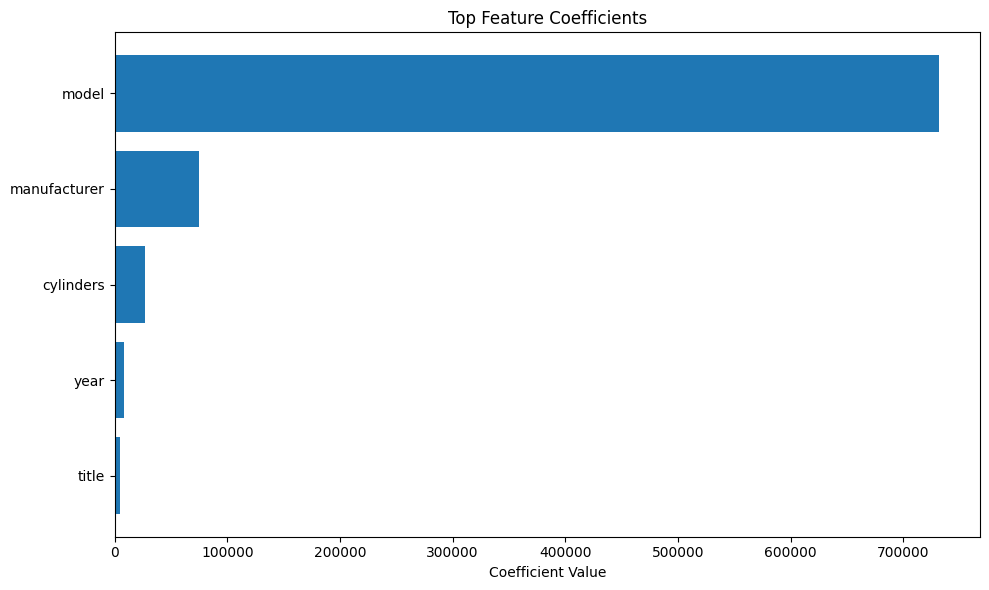

In [40]:
#Plot the top features with the highest absolute coefficient values in Ridge Regression
plt.figure(figsize=(10, 6))
plt.barh(top_features["Feature_name"], top_features["Coefficient"])
plt.xlabel("Coefficient Value")
plt.title("Top Feature Coefficients")
plt.gca().invert_yaxis()  # Invert y-axis to show highest coefficient at the top
plt.tight_layout()
plt.savefig("images/top-features.png")
plt.show()

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

##### Summary

The analysis shows that newer cars are generally expensive over the older ones. After trying multiple data models, Ridge Regression with GridSearchCV has the best RMSE.
The influential features in predicting car prices are model, manufacture, cylinders, year and title. Model is the most important feature any buyer will look for. After that manufacturer feature is a critical one. Car dealers should also pay a good attention to cylinders, year and the title of the car.
The remaining features are secondary but still useful in the car sale.

